In [1]:
import sys
import time
import random
import datetime
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
from IPython.display import clear_output
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras import mixed_precision

from utils.plot_utils import plot_iou_trainId, plot_iou_catId
from utils.data_utils import get_labels, parse_record, get_dataset_from_tfrecord
from models.hrnet_seg_gn import HRNet
# from models.hrnet_seg import HRNet

from data_loader import DataLoader
from train_utils import TrainAccumilator
from custom_callbacks import ReduceLROnPlateau

K.clear_session()
physical_devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

def enable_amp():
    mixed_precision.set_global_policy("mixed_float16")
    
print("Tensorflow version: ", tf.__version__)
print(physical_devices,"\n")
enable_amp() 

Tensorflow version:  2.4.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] 

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2070 SUPER, compute capability 7.5


/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:54: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.4.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
fine = True

img_height = 384
img_width = 768
n_classes = 20
BATCH_SIZE = 2
BUFFER_SIZE = 300

labels = get_labels()
trainid2label = { label.trainId : label for label in labels }
catid2label = { label.categoryId : label for label in labels }

pipeline = DataLoader(img_height=img_height, img_width=img_width, n_classes=n_classes, sparse=True)

In [3]:
if fine:
    train_tfrecord_dir = "records/trainIds_train.record"
    test_tfrecord_dir = "records/trainIds_val.record"
    TRAIN_LENGTH = 2975
    TEST_LENGTH = 500
    train_ds = get_dataset_from_tfrecord(train_tfrecord_dir)
    test_ds = get_dataset_from_tfrecord(test_tfrecord_dir)
else:
    train_tfrecord_dir = "records/trainIds_train_extra.record"
    TRAIN_LENGTH = 18000
    TEST_LENGTH = 1998
    all_ds = get_dataset_from_tfrecord(train_tfrecord_dir)
    train_ds = all_ds.skip(TEST_LENGTH)
    test_ds = all_ds.take(TEST_LENGTH) 


train = train_ds.map(pipeline.load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test_ds.map(pipeline.load_image_test)
eval = test_ds.map(pipeline.load_image_eval)

train_dataset = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [4]:
def label_to_rgb(mask):
    h = mask.shape[0]
    w = mask.shape[1]
    mask_rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for val, key in trainid2label.items():
        indices = mask == val
        mask_rgb[indices.squeeze()] = key.color 
    return mask_rgb


def display(display_list, title=True):
    plt.figure(figsize=(15, 5), dpi=150) # dpi=200
    if title:
        title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        if title:
            plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

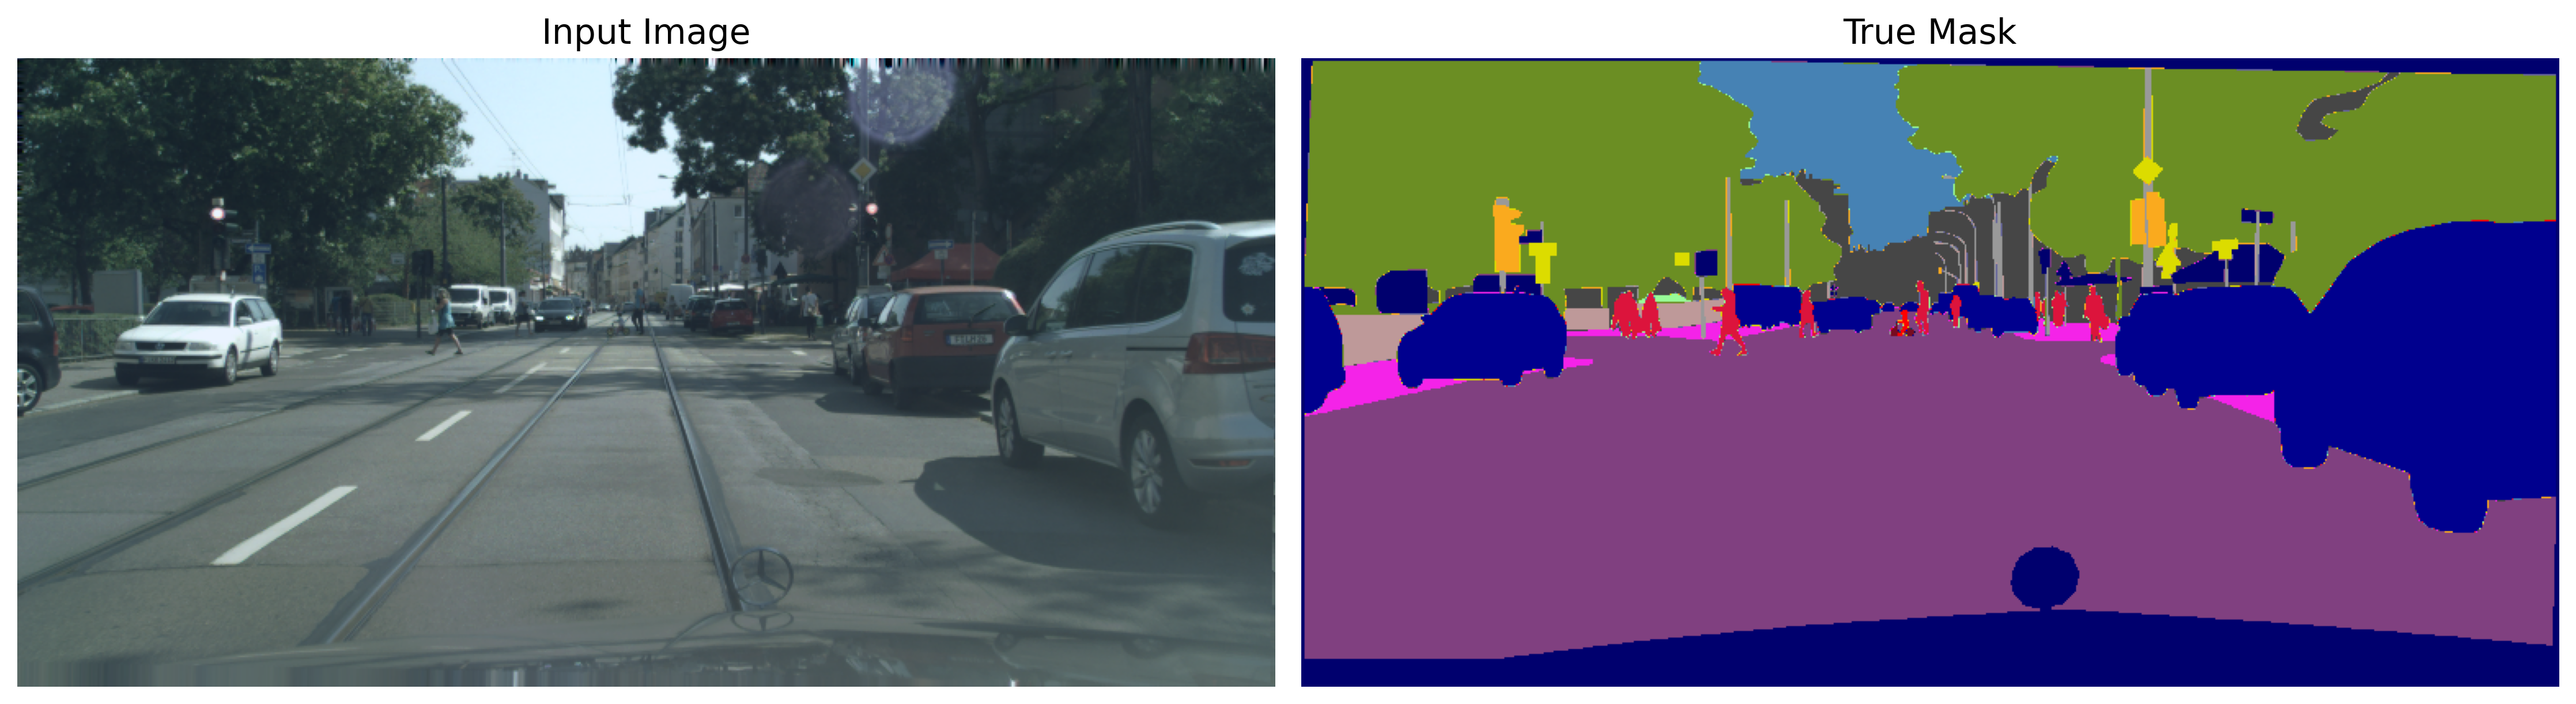

In [5]:
for image, mask in test.take(4): # 16
    sample_image, sample_mask = image, mask

if pipeline.sparse == False:
    sample_mask = tf.argmax(sample_mask, axis=-1)
sample_mask = sample_mask[..., tf.newaxis]
sample_mask = label_to_rgb(sample_mask.numpy())
display([sample_image, sample_mask])

In [6]:
# K.clear_session()

In [7]:
model = HRNet(
    stage1_cfg = {'NUM_MODULES': 1,'NUM_BRANCHES': 1,'BLOCK': 'BOTTLENECK','NUM_BLOCKS': [4]}, 
    stage2_cfg = {'NUM_MODULES': 1,'NUM_BRANCHES': 2,'BLOCK': 'BASIC',     'NUM_BLOCKS': [4, 4]},
    stage3_cfg = {'NUM_MODULES': 4,'NUM_BRANCHES': 3,'BLOCK': 'BASIC',     'NUM_BLOCKS': [4, 4, 4]},
    stage4_cfg = {'NUM_MODULES': 3,'NUM_BRANCHES': 4,'BLOCK': 'BASIC',     'NUM_BLOCKS': [4, 4, 4, 4]},
    input_height = img_height, 
    input_width = img_width, 
    n_classes = n_classes, 
    W = 32
)

In [8]:
model.summary()

Model: "HRNet_GN_W32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  1728      
_________________________________________________________________
group_normalization (GroupNo multiple                  128       
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  36864     
_________________________________________________________________
group_normalization_1 (Group multiple                  128       
_________________________________________________________________
re_lu (ReLU)                 multiple                  0         
_________________________________________________________________
sequential_1 (Sequential)    (2, 96, 192, 128)         77568     
_________________________________________________________________
sequential_2 (Sequential)    (2, 96, 192, 32)         

In [9]:
if fine:
    MODEL_PATH = "weights/"+model.name+".h5"
else:
    MODEL_PATH = "weights/"+model.name+"_coarse.h5"

# model.load_weights("weights/"+model.name+"_coarse.h5")
# model.load_weights(MODEL_PATH)

In [10]:
def create_mask(pred_mask):
    pred_mask = tf.squeeze(pred_mask)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    pred_mask = label_to_rgb(pred_mask.numpy())
    return pred_mask


def show_predictions():        
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    if "U2Net" in model.name:
        pred_mask = pred_mask[0]
    display([sample_image, sample_mask, create_mask(pred_mask)])

        
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
        
        
def iou_coef_sparse(y_true, y_pred):
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), n_classes)
    y_pred = tf.nn.softmax(y_pred, axis=-1)
    smooth = 1
    iou_total = 0
    for i in range(1, n_classes):
        intersection = tf.math.reduce_sum(y_true[:,:,:,i] * y_pred[:,:,:,i], axis=(1,2))
        union = tf.math.reduce_sum(y_true[:,:,:,i] + y_pred[:,:,:,i], axis=(1,2)) 
        iou = tf.math.reduce_mean(tf.math.divide_no_nan(2.*intersection+smooth, union+smooth), axis=0)
        iou_total += iou
    return iou_total/(n_classes-1)

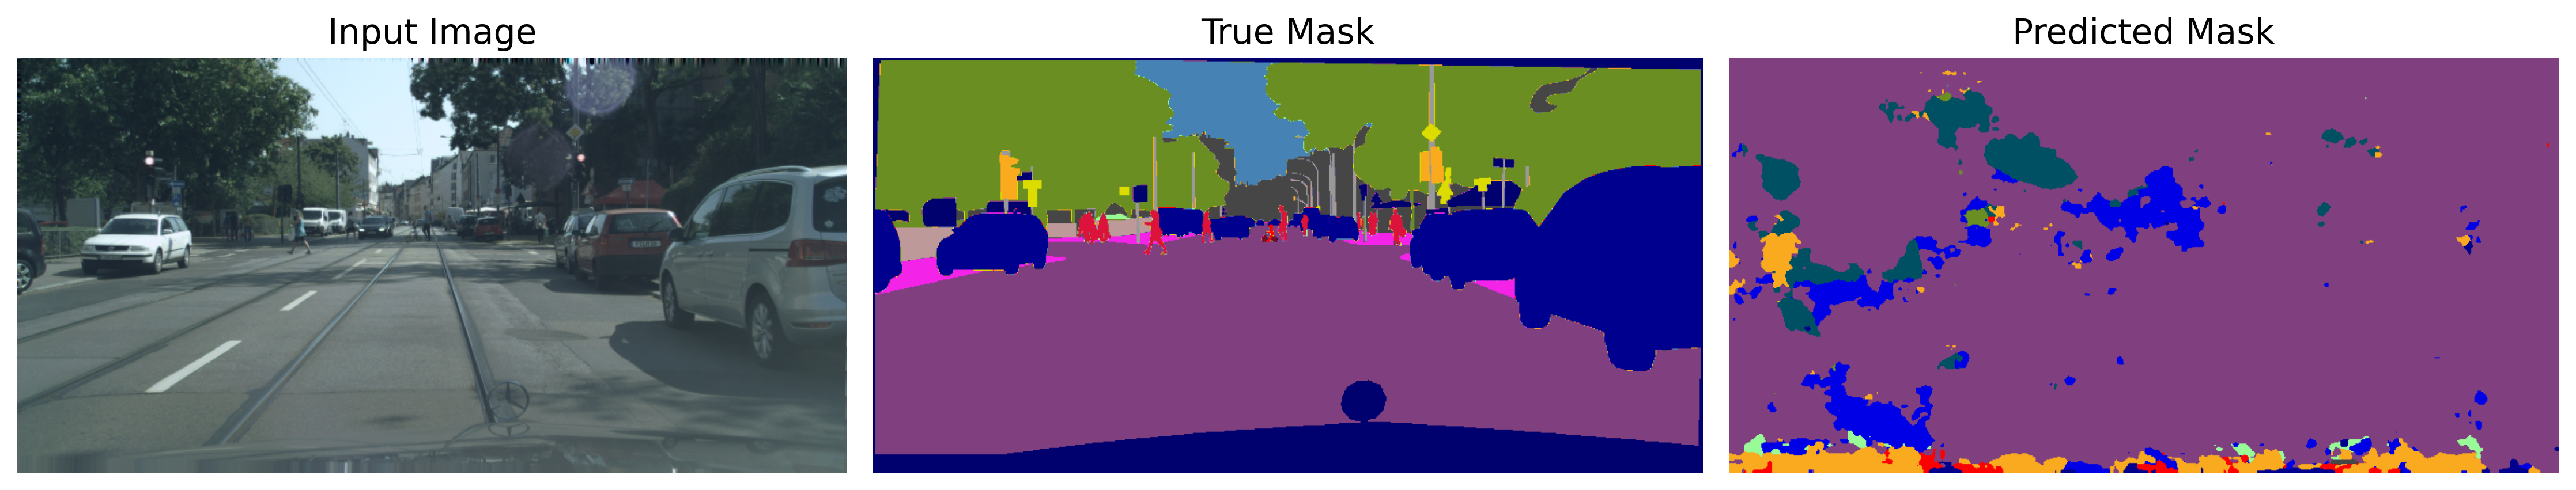

In [11]:
show_predictions()

In [12]:
! nvidia-smi

Sat May 15 23:25:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 207...  Off  | 00000000:08:00.0  On |                  N/A |
| 41%   51C    P2    65W / 215W |   6843MiB /  7948MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
EPOCHS = 100
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE 
VALIDATION_STEPS = TEST_LENGTH // BATCH_SIZE 
DECAY_STEPS = STEPS_PER_EPOCH * EPOCHS

In [14]:
def weighted_cross_entropy_loss(y_true_labels, y_pred_logits):
    c_weights = [0.0,    2.602,  6.707,  3.522,  9.877, 
                 9.685,  9.398,  10.288, 9.969,  4.336, 
                 9.454,  7.617,  9.405,  10.359, 6.373, 
                 10.231, 10.262, 10.264, 10.394, 10.094] 
    
    losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true_labels, logits=y_pred_logits)  
    weights = tf.gather(c_weights, y_true_labels)  
    losses = tf.multiply(losses, weights)
    return tf.math.reduce_mean(losses)

In [15]:
trainer = TrainAccumilator(
    model = model,
    optimizer = mixed_precision.LossScaleOptimizer(Adam(learning_rate=1e-3)),
    loss_fn = weighted_cross_entropy_loss,
    n_classes = n_classes,
    reduce_lr_on_plateau = None,
    accum_steps = 3,
)

In [ ]:
results = trainer.fit(
    epochs = EPOCHS,
    train_dataset = train_dataset,
    test_dataset = test_dataset, 
    weights_path = MODEL_PATH
)

1488it [08:45,  2.83it/s]



Epoch 1 -- 566.16s -- loss: 5.6747 , accuracy: 0.6379, miou: 0.1496, val_loss: 5.2490, val_accuracy: 0.4752, val_miou: 0.1340, lr: 0.0010000000


1488it [07:24,  3.35it/s]



Epoch 2 -- 475.53s -- loss: 4.2048 , accuracy: 0.7254, miou: 0.2132, val_loss: 3.5124, val_accuracy: 0.6976, val_miou: 0.2224, lr: 0.0010000000


1488it [07:24,  3.34it/s]



Epoch 3 -- 476.04s -- loss: 3.6126 , accuracy: 0.7545, miou: 0.2461, val_loss: 3.1236, val_accuracy: 0.7315, val_miou: 0.2484, lr: 0.0010000000


1488it [07:24,  3.35it/s]



Epoch 4 -- 476.44s -- loss: 3.4144 , accuracy: 0.7678, miou: 0.2626, val_loss: 3.3472, val_accuracy: 0.7253, val_miou: 0.2447, lr: 0.0010000000


1488it [07:25,  3.34it/s]



Epoch 5 -- 476.51s -- loss: 3.1929 , accuracy: 0.7764, miou: 0.2749, val_loss: 2.9684, val_accuracy: 0.7392, val_miou: 0.2779, lr: 0.0010000000


724it [03:45,  3.24it/s]

In [ ]:
results = trainer.history

In [ ]:
def plot_history(results, model):
         
    plt.figure(figsize=(15,7))
    plt.subplot(1,3,1)  

    plt.plot(results['loss'], 'r', label='Training loss')
    plt.plot(results['val_loss'], 'b', label='Validation loss')
    plt.title("Loss: "+model.name, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(prop={'size': 14})

    plt.subplot(1,3,2)
    plt.plot(results['accuracy'], 'r', label='Training accuracy')
    plt.plot(results['val_accuracy'], 'b', label='Validation accuracy')
    plt.title('Accuracy: '+model.name, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(prop={'size': 14})

    plt.subplot(1,3,3)
    plt.plot(results['miou'], 'r', label='IoU coefficient')
    plt.plot(results['val_miou'], 'b', label='Validation IoU coefficient')
    plt.title('IoU Coefficient: '+model.name, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(prop={'size': 14})
    if fine:
        plt.savefig("plots/"+model.name+"_learning_curves.png")
    else:
        plt.savefig("plots/"+model.name+"_learning_curves_coarse.png")
    plt.show()

In [ ]:
plot_history(results, model)

### Evaluation


In [ ]:
# K.clear_session()
# model = U2NET(input_height=img_height, input_width=img_width, n_classes=20)
# model = ERFNet(input_height=img_height, input_width=img_width, n_classes=20)

In [ ]:
# model.load_weights("weights/U2Net_latest.h5")
# model.load_weights("weights/ERFNet.h5")

In [ ]:
model.load_weights(MODEL_PATH)

In [ ]:
def evaluate_iou(model, dataset, n_samples):
    
    inf_times = np.zeros((n_samples, ))
    miou_op =  tf.keras.metrics.MeanIoU(num_classes=n_classes-1)
    
    for idx, (image, mask) in enumerate(dataset):
        print("\r Predicting {} \ {} ".format(idx+1, n_samples), end='')
        
        X = np.expand_dims(image.numpy(), axis=0)
        y_true = np.expand_dims(mask.numpy(), axis=0)
        
        t_start = time.time()
        y_pred = model.predict(X)
        t_end = time.time()
        t_inf = t_end-t_start
        
        inf_times[idx] = t_inf
        
        if "U2Net" in model.name:
            y_pred = y_pred[0]
            
        y_pred = tf.image.resize(y_pred, (1024, 2048))
        threshold = tf.math.reduce_max(y_pred, axis=-1, keepdims=True)
        y_pred = tf.logical_and(y_pred >= threshold, tf.abs(y_pred) > 1e-12)
        
        y_pred = tf.cast(tf.squeeze(y_pred, axis=0), tf.int32)
        y_true = tf.cast(tf.squeeze(y_true, axis=0), tf.int32)
        
        if pipeline.sparse == False:
            y_true = tf.argmax(y_true[:,:,1:], axis=-1)
        else:
            y_true = tf.one_hot(tf.cast(y_true, tf.int32), n_classes)
            y_true = tf.argmax(y_true[:,:,1:], axis=-1)
        y_pred = tf.argmax(y_pred[:,:,1:], axis=-1)
                
        miou_op.update_state(y_true, y_pred)
        
        if idx == (n_samples-1):
            break
    
    print("Average inference time: {:.2f}s".format(np.mean(inf_times)))
            
    return miou_op

In [ ]:
miou_op = evaluate_iou(model=model, dataset=eval, n_samples=TEST_LENGTH)
iou_mean = miou_op.result().numpy()

In [ ]:
union_int = np.sum(miou_op.get_weights()[0], axis=0)+np.sum(miou_op.get_weights()[0], axis=1)
inters = np.diag(miou_op.get_weights()[0])
ious = inters / (union_int-inters+1)

In [ ]:
plot_iou_trainId(
    trainId_label_map=trainid2label,
    catId_label_map=catid2label, 
    n_classes=n_classes, 
    iou_class=ious,
    model=model, 
    iou_mean=iou_mean,
)

In [ ]:
def visualize_confusion_matrix(confusion, metric, label_classes, model):
    plt.figure(figsize=(14,14))
    plt.title("{} Confusion Matrix, with Mean IoU = {:.3f}".format(model.name, metric), fontsize=22)
    plt.imshow(confusion)
    ax, fig = plt.gca(), plt.gcf()
    plt.xticks(np.arange(len(label_classes)), label_classes)
    plt.yticks(np.arange(len(label_classes)), label_classes)
    # set horizontal alignment mode (left, right or center) and rotation mode(anchor or default)
    plt.setp(ax.get_xticklabels(), rotation=-90, ha="center", rotation_mode="default")
    # avoid top and bottom part of heatmap been cut
    ax.set_xticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.set_yticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.grid(False)
    fig.tight_layout()
    plt.show()

In [ ]:
visualize_confusion_matrix(
    confusion = miou_op.get_weights()[0] / np.sum(miou_op.get_weights()[0], axis=0), 
    metric = iou_mean, 
    label_classes = [trainid2label[i].name for i in range(1, n_classes)],
    model = model
)

In [ ]:
def show_predictions(sample_image, sample_mask):        
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    if "U2Net" in model.name:
        pred_mask = pred_mask[0]
    # sample_mask = tf.argmax(sample_mask, axis=-1)
    sample_mask = sample_mask[..., tf.newaxis]
    sample_mask = label_to_rgb(sample_mask.numpy())
    display([sample_image, sample_mask, create_mask(pred_mask)])

In [ ]:
for image, mask in test.take(96): # 16
    sample_image, sample_mask = image, mask
show_predictions(sample_image, sample_mask)

In [ ]:
for image, mask in test.take(4): # 16
    sample_image, sample_mask = image, mask
show_predictions(sample_image, sample_mask)

In [ ]:
for image, mask in test.take(27): # 16
    sample_image, sample_mask = image, mask
show_predictions(sample_image, sample_mask)